In [79]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from collections import Counter
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset
from torchvision import models
import torch.optim as optim
import copy
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [163]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models.video import r3d_18
from collections import deque
import requests
import json
import datetime
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [1]:
# import kagglehub
# kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [5]:
# --- Data Augmentation & Transformation ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# For validation and test, use only resizing and normalization (no random augmentations)
val_transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
# --- Dataset Loader for Static Images ---
class StaticImageDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx] if self.labels else -1
        return image, label

In [166]:
# Define a mapping from folder names to GRF class labels
folder_to_grf = {
    "asphalt_dry": 6, "concrete_dry": 6, "cobble_dry": 6,
    "asphalt_damp": 5, "concrete_damp": 5, "cobble_damp": 5,
    "fully_packed": 4,
    "asphalt_wet": 3, "concrete_wet": 3, "cobble_wet": 3,
    "asphalt_verywet": 2, "concrete_verywet": 2, "cobble_verywet": 2,
    "fresh_snow": 1,
    "partially_covered": 0
}

# Collect paths from both datasets
base_dirs = [
    "/kaggle/input/roadsawds/RoadSC150_l/RoadSC-balanced_to_RoadSaW12-150_l/train",
    "/kaggle/input/roadsawds/RoadSaW-075_s/RoadSaW-075_s/train"
]

image_paths, labels = [], []
for base_dir in base_dirs:
    for folder in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, folder)
        if os.path.isdir(class_dir) and folder in folder_to_grf:
            for file in os.listdir(class_dir):
                if file.lower().endswith((".jpg", ".jpeg", ".png")):
                    image_paths.append(os.path.join(class_dir, file))
                    labels.append(folder_to_grf[folder])

In [167]:
# Load the data
dataset = StaticImageDataset(image_paths, labels, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
# --- GRF Classifier ---
class GRFClassifier(nn.Module):
    def __init__(self, base='efficientnet_b3', num_classes=7):
        super(GRFClassifier, self).__init__()
        if base == 'mobilenetv2':
            self.model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
            in_features = self.model.classifier[1].in_features
            self.model.classifier[1] = nn.Linear(in_features, num_classes)
        else:
            self.model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
            in_features = self.model.classifier[1].in_features
            self.model.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRFClassifier().to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:01<00:00, 44.6MB/s]


In [22]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
# Add learning rate scheduler to support early stopping loop
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [168]:
# --- Validation and Test Loaders ---
val_dirs = [
    "/kaggle/input/roadsawds/RoadSC150_l/RoadSC-balanced_to_RoadSaW12-150_l/validation",
    "/kaggle/input/roadsawds/RoadSaW-075_s/RoadSaW-075_s/validation"
]

test_dirs = [
    "/kaggle/input/roadsawds/RoadSC150_l/RoadSC-balanced_to_RoadSaW12-150_l/test",
    "/kaggle/input/roadsawds/RoadSaW-075_s/RoadSaW-075_s/test"
]

folder_to_grf = {
    "asphalt_dry": 6, "concrete_dry": 6, "cobble_dry": 6,
    "asphalt_damp": 5, "concrete_damp": 5, "cobble_damp": 5,
    "fully_packed": 4,
    "asphalt_wet": 3, "concrete_wet": 3, "cobble_wet": 3,
    "asphalt_verywet": 2, "concrete_verywet": 2, "cobble_verywet": 2,
    "fresh_fallen": 1,
    "partially_covered": 0
}

val_paths, val_labels = [], []
for base_dir in val_dirs:
    for folder in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, folder)
        if os.path.isdir(class_dir) and folder in folder_to_grf:
            for file in os.listdir(class_dir):
                if file.lower().endswith((".jpg", ".jpeg", ".png")):
                    val_paths.append(os.path.join(class_dir, file))
                    val_labels.append(folder_to_grf[folder])

val_dataset = StaticImageDataset(val_paths, val_labels, val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_paths, test_labels = [], []
for base_dir in test_dirs:
    for folder in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, folder)
        if os.path.isdir(class_dir) and folder in folder_to_grf:
            for file in os.listdir(class_dir):
                if file.lower().endswith((".jpg", ".jpeg", ".png")):
                    test_paths.append(os.path.join(class_dir, file))
                    test_labels.append(folder_to_grf[folder])

test_dataset = StaticImageDataset(test_paths, test_labels, val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
patience = 5
trigger_times = 0

num_epochs = 20
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0

    print(f"Epoch {epoch}/{num_epochs} - Training Phase")
    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

        # if batch_idx % 10 == 0:
        #     print(f"  Batch {batch_idx}/{len(dataloader)} - Loss: {loss.item():.4f}")

    train_loss = running_loss / total
    train_acc = running_correct / total
    print(f"[Train] Epoch {epoch} Summary: Loss {train_loss:.4f}, Accuracy {train_acc:.4f}")
    scheduler.step()

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    print(f"[Validation] Epoch {epoch} Summary: Loss {val_loss:.4f}, Accuracy {val_acc:.4f}")

    # --- Early Stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        trigger_times = 0
        torch.save(model.state_dict(), "best_model_checkpoint.pth")
        print("  ✅ Checkpoint saved (best model so far)")
    else:
        trigger_times += 1
        print(f"  ⚠️ No improvement for {trigger_times} epoch(s)")
        if trigger_times >= patience:
            print("⛔ Early stopping triggered")
            break

# Load best model weights after training
model.load_state_dict(best_model_wts)

Epoch 1/20 - Training Phase
[Train] Epoch 1 Summary: Loss 0.4144, Accuracy 0.8218
[Validation] Epoch 1 Summary: Loss 0.8590, Accuracy 0.7063
  ✅ Checkpoint saved (best model so far)
Epoch 2/20 - Training Phase
[Train] Epoch 2 Summary: Loss 0.3719, Accuracy 0.8409
[Validation] Epoch 2 Summary: Loss 0.7979, Accuracy 0.7026
  ✅ Checkpoint saved (best model so far)
Epoch 3/20 - Training Phase
[Train] Epoch 3 Summary: Loss 0.3422, Accuracy 0.8504
[Validation] Epoch 3 Summary: Loss 0.8981, Accuracy 0.6960
  ⚠️ No improvement for 1 epoch(s)
Epoch 4/20 - Training Phase
[Train] Epoch 4 Summary: Loss 0.3096, Accuracy 0.8664
[Validation] Epoch 4 Summary: Loss 0.8590, Accuracy 0.6979
  ⚠️ No improvement for 2 epoch(s)
Epoch 5/20 - Training Phase
[Train] Epoch 5 Summary: Loss 0.2742, Accuracy 0.8837
[Validation] Epoch 5 Summary: Loss 0.9091, Accuracy 0.7107
  ⚠️ No improvement for 3 epoch(s)
Epoch 6/20 - Training Phase
[Train] Epoch 6 Summary: Loss 0.2549, Accuracy 0.8885
[Validation] Epoch 6 Summa

<All keys matched successfully>

In [27]:
# --- Evaluation ---
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       489
           1       0.00      0.00      0.00         0
           2       0.69      0.74      0.71      1236
           3       0.75      0.60      0.67      1236
           4       1.00      0.95      0.97       489
           5       0.60      0.55      0.58      1236
           6       0.54      0.64      0.58      1236

    accuracy                           0.69      5922
   macro avg       0.65      0.64      0.64      5922
weighted avg       0.70      0.69      0.69      5922



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


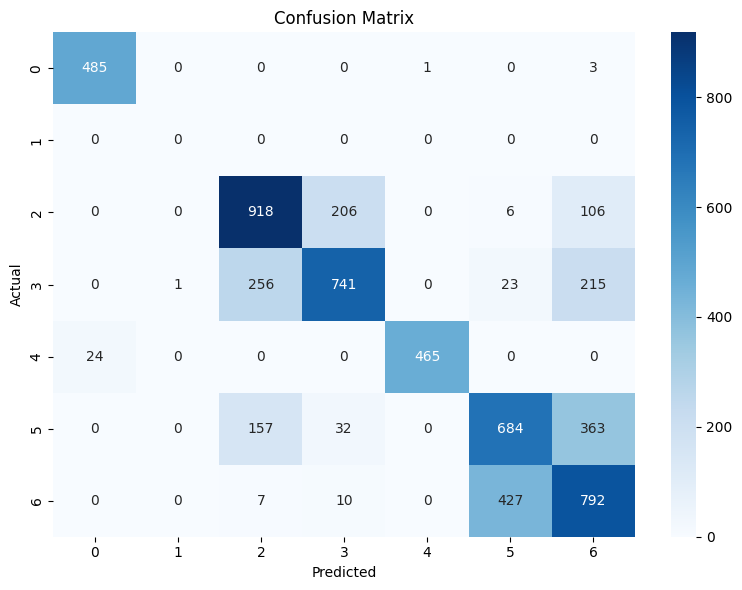

In [18]:
evaluate_model(model, val_loader, device)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       191
           2       0.68      0.72      0.70       429
           3       0.72      0.57      0.64       429
           4       1.00      1.00      1.00       191
           5       0.61      0.76      0.68       429
           6       0.71      0.66      0.69       429

    accuracy                           0.73      2098
   macro avg       0.79      0.78      0.78      2098
weighted avg       0.74      0.73      0.73      2098



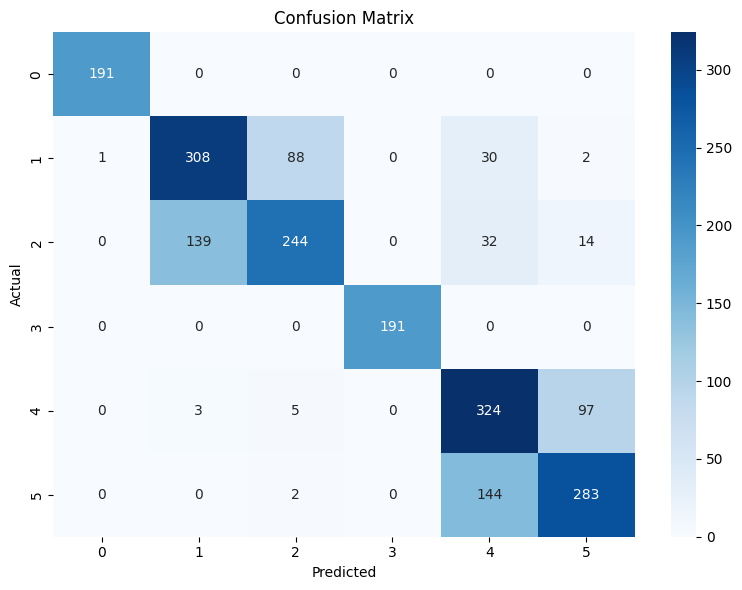

In [28]:
evaluate_model(model, test_loader, device)

In [112]:
def detect_trend(class_sequence):
    if len(class_sequence) < 2:
        return "Stable"
    if class_sequence[-1] > class_sequence[0]:
        return "Improving"
    elif class_sequence[-1] < class_sequence[0]:
        return "Worsening"
    else:
        return "Stable"

In [164]:
def generate_grf_report(runway, code, trend, forecast, weather):
    description_map = {
        6: "DRY",
        5: "WET",
        4: "COMPACTED SNOW",
        3: "WET",
        2: "STANDING WATER",
        1: "ICE",
        0: "WET ICE"
    }
    now = datetime.datetime.utcnow().isoformat() + "Z"
    return {
        "timestamp": now,
        "location": runway,
        "runway_condition_code": code,
        "runway_condition_description": description_map.get(code, "UNKNOWN"),
        "trend_analysis": trend,
        "forecast_next_5min": forecast,
        "temperature": weather.get('temp'),
        "precipitation": weather.get('precip'),
        "coverage": weather.get('coverage'),
        "icao_snowtam_format": f"RWY {runway} {code} / {description_map.get(code)} / TREND: {trend} / TEMP {weather.get('temp')}C / PRECIP {weather.get('precip')}"
    }

In [101]:
# --- Feature Extraction ---
def extract_visual_features(model, frames, layer='avgpool'):
    hooks = {}

    def hook_fn(module, input, output):
        hooks['feat'] = output.flatten(start_dim=1)

    h = getattr(model.model, layer).register_forward_hook(hook_fn)
    _ = model(frames)
    h.remove()
    return hooks['feat']

In [102]:
class GRF3DCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(GRF3DCNN, self).__init__()
        self.model = r3d_18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [103]:
def prepare_video_tensor(image_sequence, num_frames=16):
    if len(image_sequence) < num_frames:
        image_sequence = [image_sequence[0]] * (num_frames - len(image_sequence)) + image_sequence
    else:
        image_sequence = image_sequence[-num_frames:]
    video_tensor = torch.stack(image_sequence).permute(1, 0, 2, 3).unsqueeze(0)  # (C, T, H, W) -> (1, C, T, H, W)
    return video_tensor

In [104]:
def run_trend_analysis_3dcnn(model_3d, image_sequence, num_frames=5):
    model_3d.eval()
    with torch.no_grad():
        video_tensor = prepare_video_tensor(image_sequence, num_frames=num_frames).to(device)
        outputs = model_3d(video_tensor)
        predicted = torch.argmax(outputs, dim=1).item()
        return predicted


In [105]:
def visualize_sequence_with_predictions(image_sequence, reports):
    fig, axes = plt.subplots(len(image_sequence), 1, figsize=(6, len(image_sequence) * 2.5))
    if len(image_sequence) == 1:
        axes = [axes]

    for i, (img_tensor, report) in enumerate(zip(image_sequence, reports)):
        img = img_tensor.permute(1, 2, 0).cpu().numpy()
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"GRF Code: {report['runway_condition_code']} ({report['runway_condition_description']}) Trend: {report['trend_analysis']}")

    plt.tight_layout()
    plt.show()

In [119]:
def plot_trends(reports, forecast_code=None):
    timestamps = [r['timestamp'] for r in reports]
    codes = [r['runway_condition_code'] for r in reports]
    forecasts = [r['forecast_next_5min'] for r in reports]

    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, codes, label='Observed GRF Code', marker='o')

    if forecast_code is not None:
        plt.plot(timestamps, [forecast_code] * len(timestamps), label='Regressed Forecast Code', linestyle='-.', marker='s', color='green')

    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Timestamp")
    plt.ylabel("GRF Code")
    plt.title("Runway Condition Trends and Forecasts")
    plt.legend()
    plt.tight_layout()
    plt.show()


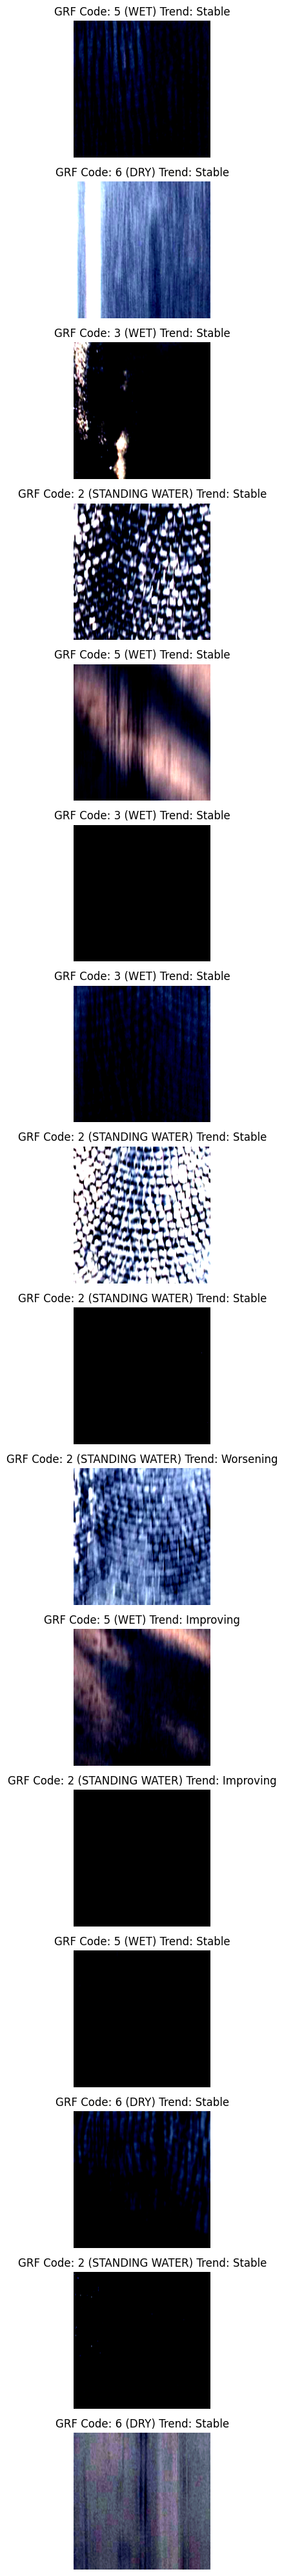

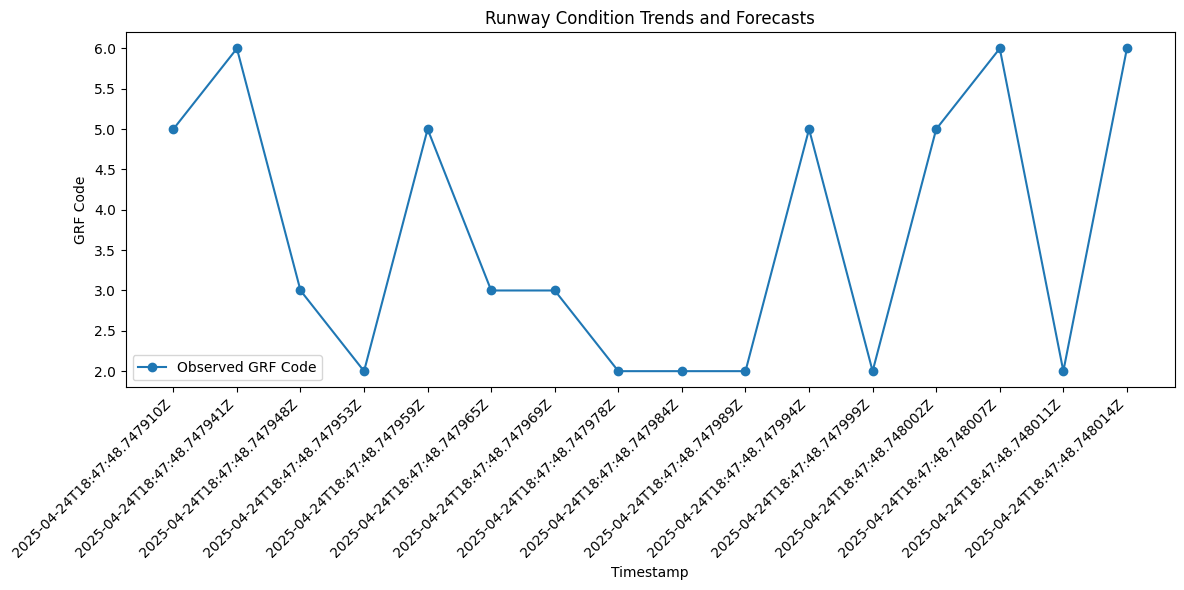

In [165]:
# Example setup (adjust paths and loading logic to your environment)
from PIL import Image
import datetime

# Step 1: Load a short sequence of randomly selected images and apply transforms
import random
sample_paths = random.sample(image_paths, k=16)
image_sequence = [transform(Image.open(p).convert("RGB")).to(device) for p in sample_paths]  # Adjust paths

# Step 2: Run 2D classifier on each image to get GRF codes (mocked here for demo)
model.eval()
grfs = []
with torch.no_grad():
    for img in image_sequence:
        output = model(img.unsqueeze(0))
        grf_code = torch.argmax(output, dim=1).item()
        grfs.append(grf_code)

# Step 3: Run 3D CNN on the sequence to detect trend
trend_code = run_trend_analysis_3dcnn(model_3d, image_sequence)

# Step 4: Create reports
weather_data = {'temp': 2.5, 'precip': 'light snow', 'coverage': '65%'}

# Step 4.1: Generate 3D CNN GRF predictions over rolling windows
trend_classes = [run_trend_analysis_3dcnn(model_3d, image_sequence[i:i+5], num_frames=5) for i in range(len(image_sequence)-4)]
trend_classes = [trend_classes[0]] * 4 + trend_classes  # pad to match full length
trend_classes = [run_trend_analysis_3dcnn(model_3d, image_sequence[i:i+5], num_frames=5) for i in range(len(image_sequence)-4)]

results = []
for i, code in enumerate(grfs):
    trend_window = trend_classes[max(0, i-4):i+1]
    trend_label = detect_trend(trend_window) if len(trend_window) >= 5 else "Stable"
    report = generate_grf_report("01A", code, trend_label, trend_code, weather_data)
    results.append(report)

# Step 5: Visualize
visualize_sequence_with_predictions(image_sequence, results)
plot_trends(results)